## adapted from: https://github.com/nzw0301/keras-examples/blob/master/CBoW.ipynb

In [1]:
import os,re,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import pickle

np.random.seed(42)

from nltk import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords

import keras.backend as K
from keras.models import Sequential,Model
from keras.layers import Dense, Embedding, Lambda, Input, Concatenate, Average
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from keras.optimizers import Adadelta

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from tqdm import *

import gensim

%matplotlib inline
%load_ext autoreload
%autoreload 1

src_dir = os.path.join(os.getcwd(), os.pardir, '../../')
sys.path.append(src_dir)

%aimport src.data.movielens_20m_imdb
%aimport src.helpers.labels,src.helpers.neighbours, src.helpers.segments
%aimport src.utils.dataframes, src.utils.clusters, src.utils.metrics

from src.data.movielens_20m_imdb import load_df_or_get_from_cache
from src.helpers.labels import truncate_labels
from src.helpers.neighbours import get_predicted_labels_from_neighbours
from src.helpers.segments import make_distance_matrix_for_segments,vectorize_segments

from src.utils.dataframes import sample_rows
from src.utils.metrics import ranking

MODELS_ROOT = os.path.abspath("../../../models/ranking/")
INTERIM_DATA_ROOT = os.path.abspath("../../../data/interim/movielens-ml20m-imdb/")
PATH_TO_PROCESSED_FILE = os.path.abspath('../../../data/processed/movielens-20m-imdb-tags-and-synopses-2017-12-13.csv')

# CONFIGS

SEED= 42

np.random.seed(SEED)

DEFAULT_KERAS_FILTER = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

MAX_TEXT_LENGTH = 1000
NB_DOCS = 50
DIM = 100
CONTEXT_WINDOW_SIZE = 4
STOPWORDS = None
TOKENIZER_FILTERS = DEFAULT_KERAS_FILTER
NB_EPOCHS = 20

Using TensorFlow backend.


In [2]:
docs_df = load_df_or_get_from_cache(PATH_TO_PROCESSED_FILE,INTERIM_DATA_ROOT)
docs_df = sample_rows(docs_df,NB_DOCS)
corpus = docs_df['synopsis'].values

In [3]:
tokenizer = Tokenizer(filters=TOKENIZER_FILTERS)
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)

In [4]:
VOCAB_SIZE=len(tokenizer.word_index) + 1

In [5]:
input1 = Input(shape=(CONTEXT_WINDOW_SIZE*2,))
x1 = Embedding(VOCAB_SIZE,output_dim=DIM,name="word_embeddings")(input1)
x1 = Lambda(lambda x: K.mean(x, axis=1), output_shape=(DIM,))(x1)

outputs = Dense(VOCAB_SIZE,activation='softmax')(x1)

cbow = Model(inputs=input1,outputs=outputs)

In [6]:
cbow.compile(loss='categorical_crossentropy', optimizer='adagrad')

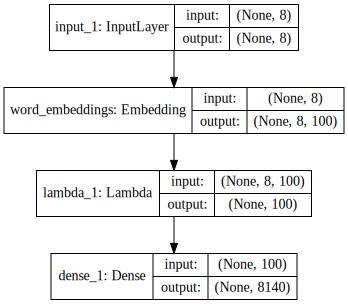

In [7]:
SVG(model_to_dot(cbow,show_shapes=True).create(prog='dot', format='svg'))

In [8]:
def generate_data(document_sequences, window_size, vocabulary_size):
    
    maxlen = window_size*2
    
    for word_sequence in document_sequences:
               
        text_length = len(word_sequence)
        
        for index_in_document,word in enumerate(word_sequence):
            
            # these are the words in the context
            contexts = []
            # these are the target words (which we'll predict using the context)
            labels = []
                        
            context_start = index_in_document - window_size           
            context_end   = index_in_document + window_size
            
            context = []
            
            for index_in_context in range(context_start, context_end+1):
                if index_in_document != index_in_context: # index_in_context is the target word
                    if index_in_context >= 0 and index_in_context < text_length: # inner_index must be a valid index
                        context_word = word_sequence[index_in_context]
                        context.append(context_word)
                        
            contexts.append(context)
                       
            labels.append(word)
            
            x = sequence.pad_sequences(contexts, maxlen=maxlen)
            y = np_utils.to_categorical(labels,vocabulary_size)
            
            
            yield (x,y) 

In [9]:
for epoch in range(NB_EPOCHS):
    loss = 0.
    for x, y in tqdm(generate_data(sequences, CONTEXT_WINDOW_SIZE, VOCAB_SIZE)):
        loss += cbow.train_on_batch(x, y)
    print(epoch, loss)

57641it [04:21, 220.66it/s]
23it [00:00, 223.99it/s]

0 446069.647014


57641it [04:05, 234.60it/s]
23it [00:00, 222.23it/s]

1 419264.262371


57641it [04:09, 230.82it/s]
23it [00:00, 225.30it/s]

2 412276.138731


57641it [04:29, 214.10it/s]
25it [00:00, 247.09it/s]

3 408076.373506


57641it [04:32, 211.35it/s]
23it [00:00, 229.45it/s]

4 405076.060303


57641it [04:16, 224.59it/s]
26it [00:00, 253.21it/s]

5 402690.049448


57641it [03:56, 244.09it/s]
23it [00:00, 228.83it/s]

6 400639.264996


57641it [04:09, 231.02it/s]
22it [00:00, 212.64it/s]

7 398772.944107


57641it [04:22, 220.00it/s]
22it [00:00, 212.35it/s]

8 397007.804901


57641it [04:12, 228.31it/s]
23it [00:00, 221.65it/s]

9 395302.378117


57641it [04:22, 219.89it/s]
22it [00:00, 217.82it/s]

10 393642.745139


57641it [04:11, 229.17it/s]
23it [00:00, 222.57it/s]

11 392031.443743


57641it [04:17, 224.13it/s]
23it [00:00, 222.18it/s]

12 390478.77586


57641it [04:15, 225.44it/s]
18it [00:00, 176.63it/s]

13 388996.738824


57641it [04:32, 211.50it/s]
22it [00:00, 214.86it/s]

14 387595.35157


57641it [04:11, 228.98it/s]
24it [00:00, 230.84it/s]

15 386281.714822


57641it [04:17, 223.58it/s]
26it [00:00, 251.90it/s]

16 385059.334571


57641it [04:07, 232.96it/s]
16it [00:00, 154.78it/s]

17 383928.123292


57641it [04:18, 223.25it/s]
21it [00:00, 207.26it/s]

18 382884.787867


57641it [04:08, 232.27it/s]

19 381923.524573


In [10]:
f = open('vectors.txt' ,'w')
f.write(' '.join([str(VOCAB_SIZE-1), str(DIM)]))
f.write('\n')

1

In [11]:
pairs = [ (word,i) for word,i in tokenizer.word_index.items()]

pairs = sorted(pairs,key=lambda tpl: tpl[1])

In [12]:
actually_used_word_index = dict(pairs)

In [13]:
vectors = cbow.get_weights()[0]
vectors.shape

(8140, 100)

In [14]:
for word, i in actually_used_word_index.items():
    f.write(word)
    f.write(' ')
    f.write(' '.join(map(str, list(vectors[i, :]))))
    f.write('\n')
f.close()

In [15]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

In [16]:
w2v.most_similar(positive=['i'])

[('that', 0.6086381673812866),
 ('he', 0.588042140007019),
 ('not', 0.572224497795105),
 ('will', 0.5647653341293335),
 ('can', 0.5543062686920166),
 ('because', 0.5513842105865479),
 ('may', 0.5508166551589966),
 ('him', 0.5297994613647461),
 ('says', 0.5255216360092163),
 ('it', 0.5166193842887878)]

In [17]:
w2v.most_similar(positive=['he'])

[('that', 0.8691412210464478),
 ('she', 0.8348675966262817),
 ('not', 0.8228061199188232),
 ('it', 0.8227299451828003),
 ('tells', 0.8151426315307617),
 ('her', 0.8141981959342957),
 ('will', 0.8055366277694702),
 ('him', 0.8026009202003479),
 ('but', 0.7896877527236938),
 ('was', 0.7857427597045898)]

In [18]:
w2v.most_similar(positive=['man'])

[('rest', 0.7995232343673706),
 ('celebrate', 0.7980454564094543),
 ('howls', 0.7945990562438965),
 ('group', 0.7936820983886719),
 ('missile', 0.7922608256340027),
 ('structure', 0.7911497354507446),
 ('launched', 0.7891209125518799),
 ('ground', 0.7878245115280151),
 ('murderer', 0.7875157594680786),
 ('dwindling', 0.7819898724555969)]

In [19]:
w2v.most_similar(positive=['can'])

[('that', 0.8039196729660034),
 ('will', 0.7990150451660156),
 ('says', 0.7880035638809204),
 ('tells', 0.7846977710723877),
 ('he', 0.7732518911361694),
 ('not', 0.7722700834274292),
 ('if', 0.7616811990737915),
 ('but', 0.7610113024711609),
 ('him', 0.754069447517395),
 ('she', 0.753523588180542)]

In [ ]:
path = PATH_TO_SAVED_MODELS+"/word2vec-cbow.p"

In [ ]:
cbow.save(path)